In [15]:
import os
import json
import optuna
import pandas as pd
import datetime
import warnings
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier
%matplotlib inline

In [2]:
SEED = 10801
sns.set_style(style="whitegrid")
plt.rcParams["figure.figsize"] = 12, 8
warnings.filterwarnings("ignore")

In [3]:
PATH_TO_DATA = "/home/dorzhi/BI/ML/hw6/"

df_train_features = pd.read_csv(os.path.join(PATH_TO_DATA,
                                             "train_data.csv"),
                                    index_col="match_id_hash")
df_train_targets = pd.read_csv(os.path.join(PATH_TO_DATA,
                                            "train_targets.csv"),
                                   index_col="match_id_hash")

In [4]:
df_train_features.shape

(31698, 245)

In [5]:
df_train_features.head(10)

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0.000000,0,0,0,0,0.000000,0,0,0,0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0.000000,0,0,0,0,0.000000,0,0,0,0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,0.000000,0,0,0,0,0.000000,0,0,0,0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,8.264696,0,0,3,0,0.250000,0,0,3,0
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,15.762911,3,1,0,1,0.500000,0,0,3,0
df50f738c454d430a33b2bf90cb9ef1a,636,22,7,1,5,74,1,1,0,3,...,8.064697,0,0,1,0,0.428571,0,0,1,0
7469e9440ea3d19b211a484647c7126e,1054,22,0,8,5,71,1,3,10,4,...,2.899237,0,0,11,0,0.636364,0,0,0,0
0aa1c6d7630433a93fe42da5ac810368,1797,22,7,9,2,35,1,5,2,1,...,34.424866,0,0,19,0,0.371429,0,0,0,0
892b5d40992e4b334e159f99b2bb55e6,605,22,7,0,5,30,0,1,3,1,...,0.000012,0,0,3,0,0.250000,0,0,1,0


In [6]:
df_train_targets.head()

,game_time,radiant_win,duration,time_remaining,next_roshan_team
match_id_hash,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,True,1154,496,NaN
6db558535151ea18ca70a6892197db41,21,True,1503,1482,Radiant
19c39fe2af2b547e48708ca005c6ae74,160,False,2063,1903,NaN
c96d629dc0c39f0c616d1949938a6ba6,1016,True,2147,1131,Radiant
156c88bff4e9c4668b0f53df3d870f1b,582,False,1927,1345,Dire


In [7]:
df_train_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31698 entries, b9c57c450ce74a2af79c9ce96fac144d to e2ca68ac1a6847f4a37f6c9c8ee8695b
Columns: 245 entries, game_time to d5_sen_placed
dtypes: float64(30), int64(215)
memory usage: 59.5+ MB


In [9]:
df_train_features.describe()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
count,31698.000000,31698.000000,31698.000000,31698.000000,31698.000000,31698.000000,31698.000000,31698.000000,31698.000000,31698.000000,...,31698.000000,31698.000000,31698.000000,31698.000000,31698.000000,31698.000000,31698.000000,31698.000000,31698.000000,31698.000000
mean,1146.519496,19.583538,4.771563,6.535239,7.358982,51.081614,3.151713,3.273361,4.661998,6.255600,...,11.773022,1.021957,0.338381,4.697363,0.088965,0.416247,0.299640,0.024449,1.255568,0.780933
std,766.936655,6.306635,3.260899,6.486933,13.295763,34.573173,3.727116,3.281208,5.207887,8.144267,...,20.400131,3.427767,0.946140,4.662255,0.284697,0.267604,0.730835,0.172030,2.582681,2.436478
min,0.000000,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,-3.294393,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,521.000000,22.000000,0.000000,1.000000,0.000000,20.000000,0.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.235294,0.000000,0.000000,0.000000,0.000000
50%,1044.000000,22.000000,7.000000,4.000000,3.000000,44.000000,2.000000,2.000000,3.000000,3.000000,...,1.532971,0.000000,0.000000,3.000000,0.000000,0.444444,0.000000,0.000000,0.000000,0.000000
75%,1659.000000,22.000000,7.000000,10.000000,9.000000,81.000000,5.000000,5.000000,7.000000,9.000000,...,16.129388,0.000000,0.000000,7.000000,0.000000,0.600000,0.000000,0.000000,1.000000,0.000000
max,4933.000000,23.000000,7.000000,43.000000,291.000000,120.000000,32.000000,27.000000,40.000000,83.000000,...,222.612630,107.000000,29.000000,57.000000,1.000000,2.000000,9.000000,5.000000,26.000000,47.000000


[Text(0.5, 0, 'r3_kills'),
 Text(3.5, 0, 'r4_lh'),
 Text(6.5, 0, 'd2_kills'),
 Text(9.5, 0, 'd5_lh'),
 Text(12.5, 0, 'd4_kills'),
 Text(15.5, 0, 'd1_lh'),
 Text(18.5, 0, 'd5_max_mana'),
 Text(21.5, 0, 'r4_max_mana'),
 Text(24.5, 0, 'r2_max_mana'),
 Text(27.5, 0, 'd5_rune_pickups'),
 Text(30.5, 0, 'd4_rune_pickups'),
 Text(33.5, 0, 'r2_kills'),
 Text(36.5, 0, 'r4_rune_pickups'),
 Text(39.5, 0, 'r3_rune_pickups'),
 Text(42.5, 0, 'd2_level'),
 Text(45.5, 0, 'd4_level'),
 Text(48.5, 0, 'd3_level'),
 Text(51.5, 0, 'd5_level'),
 Text(54.5, 0, 'd1_level'),
 Text(57.5, 0, 'r3_xp'),
 Text(60.5, 0, 'r2_xp'),
 Text(63.5, 0, 'r5_xp'),
 Text(66.5, 0, 'r4_xp'),
 Text(69.5, 0, 'r1_gold'),
 Text(72.5, 0, 'r3_deaths'),
 Text(75.5, 0, 'r5_deaths'),
 Text(78.5, 0, 'd1_assists'),
 Text(81.5, 0, 'd4_assists'),
 Text(84.5, 0, 'd4_max_health'),
 Text(87.5, 0, 'r3_assists'),
 Text(90.5, 0, 'r4_assists'),
 Text(93.5, 0, 'd5_deaths'),
 Text(96.5, 0, 'd4_deaths'),
 Text(99.5, 0, 'r5_max_health'),
 Text(102.5, 0,

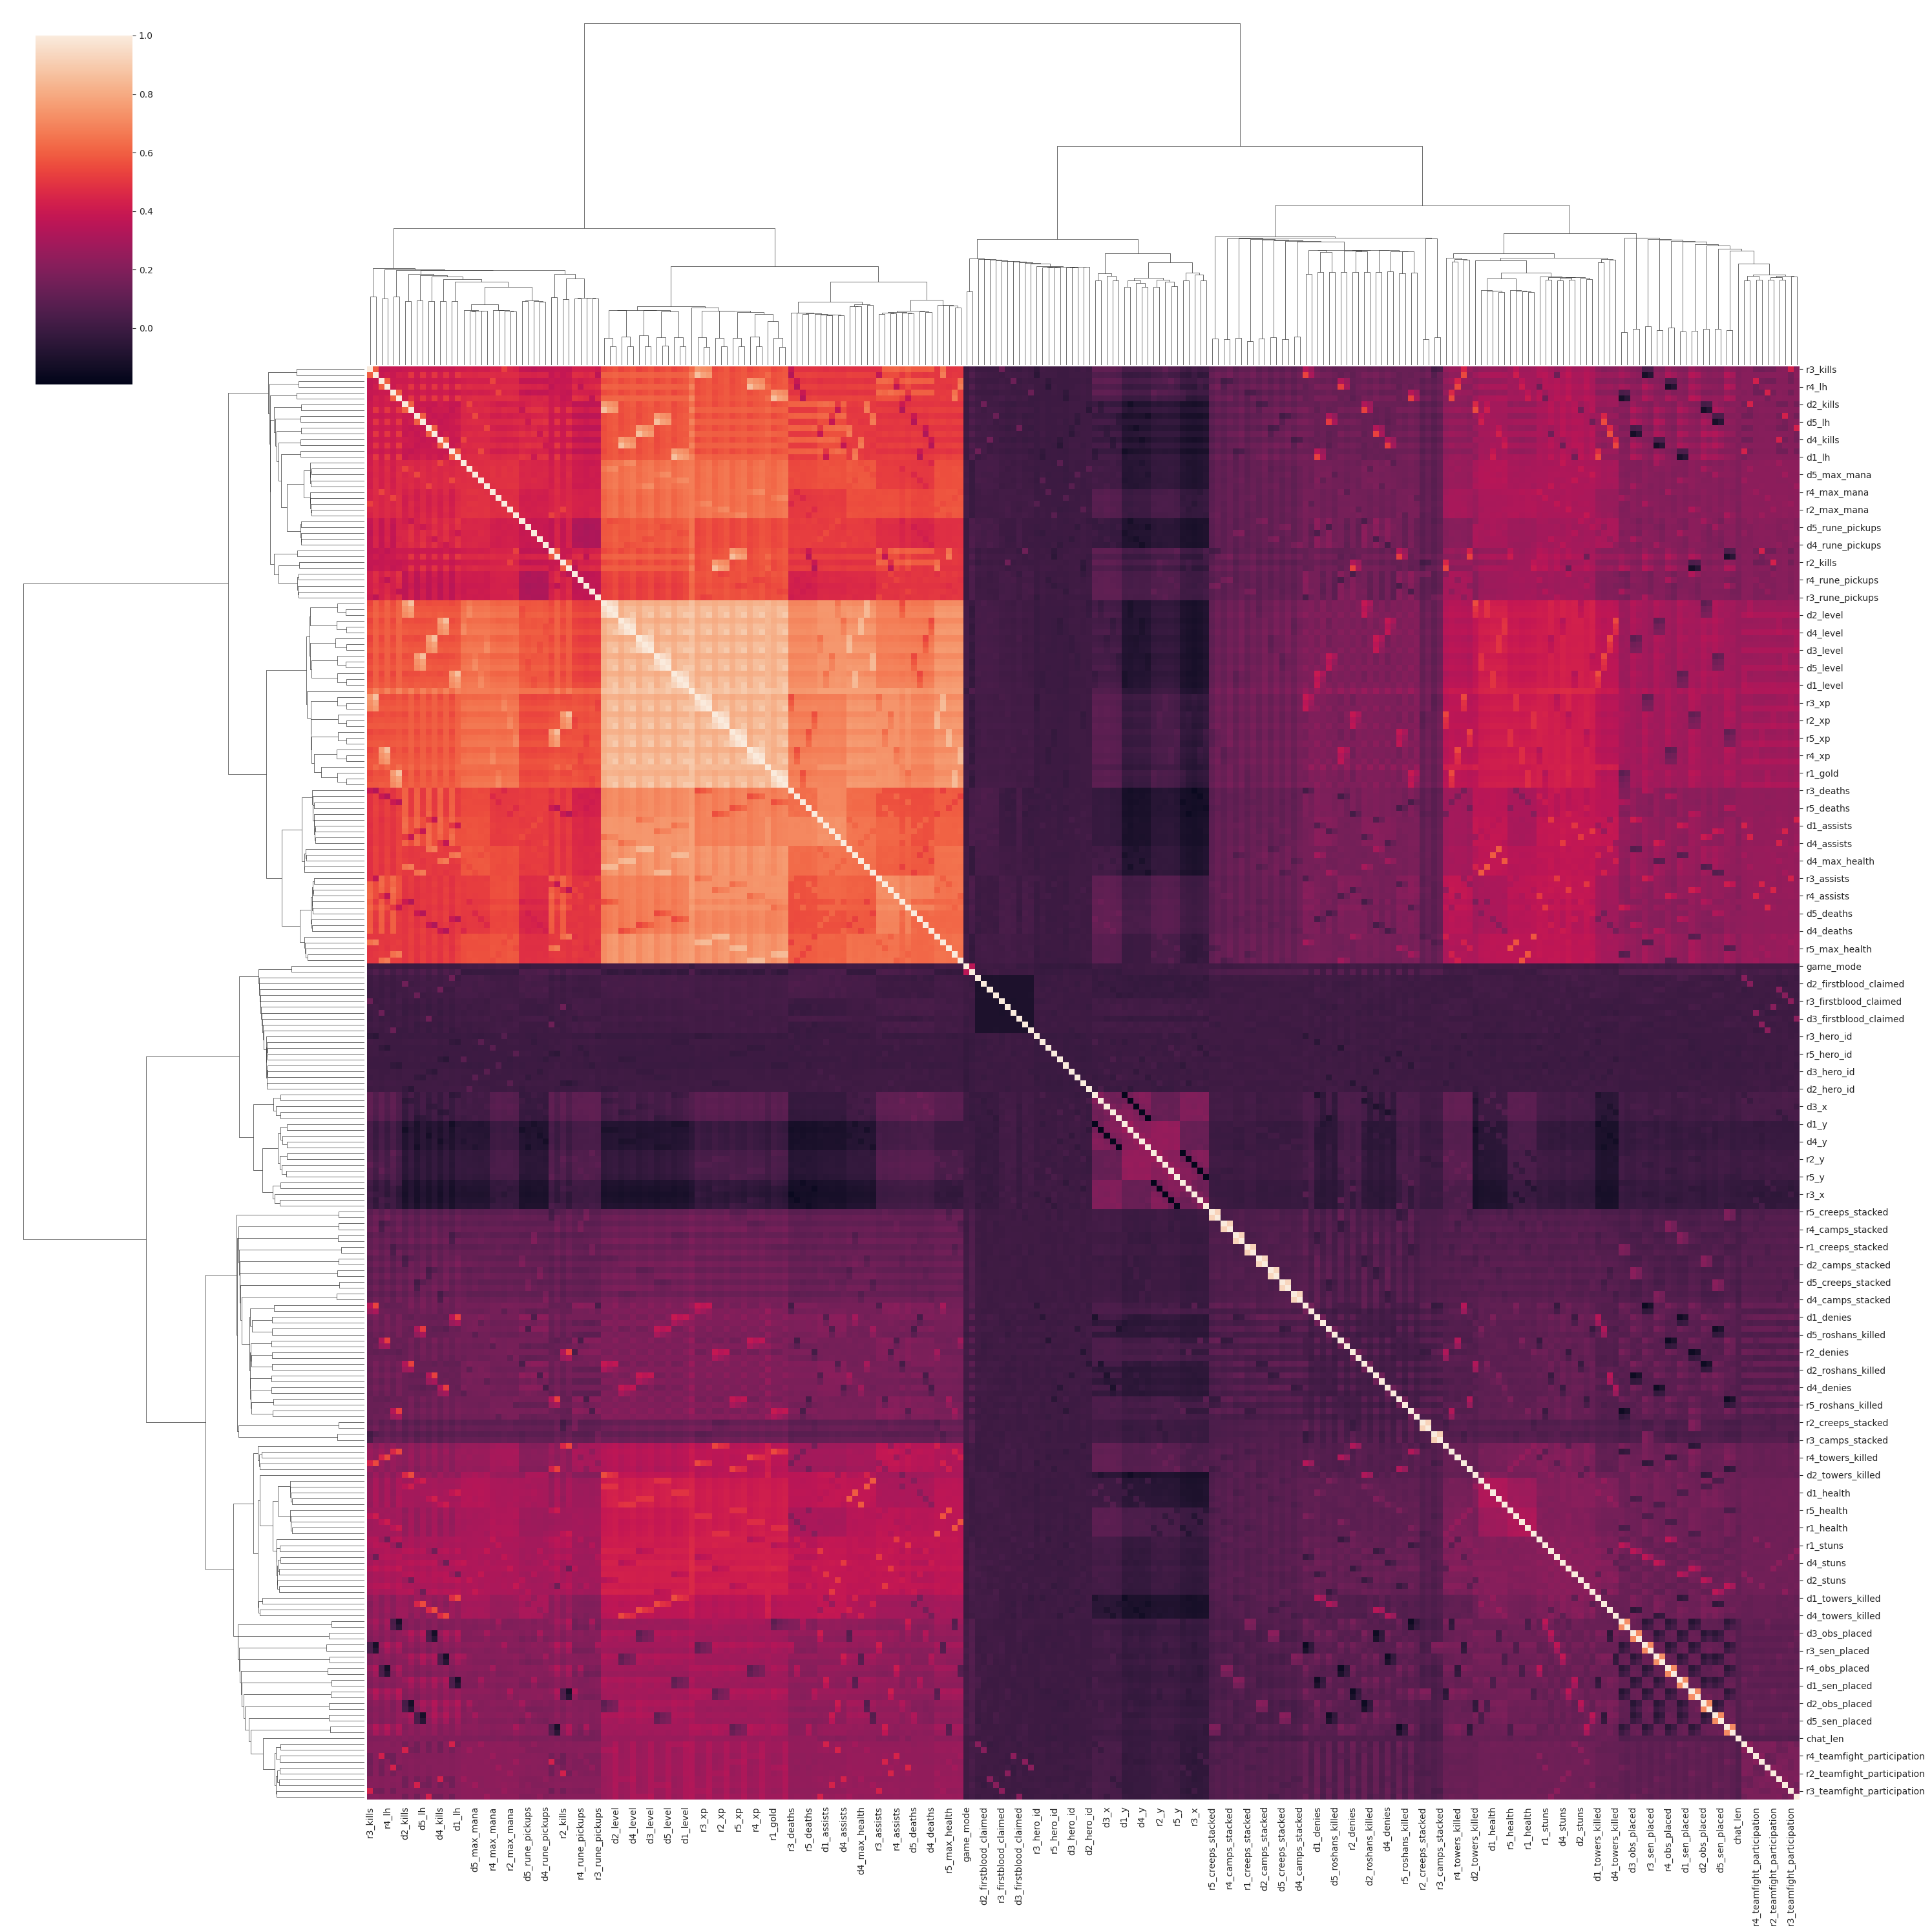

In [10]:
corr_matrix = df_train_features.corr()

fig = sns.clustermap(corr_matrix, figsize=(30, 30), cmap="rocket")
fig.ax_heatmap.set_xticklabels(fig.ax_heatmap.get_xticklabels(), rotation=90)

При рассмотрении корреляции данных было решенео, что стоит уменьшить их количество 

### Data normalization

Для начала была предпринята попытка провести нормализацию данных.

In [45]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np

scaler = StandardScaler()
data_normalized = scaler.fit_transform(df_train_features)

Нормализация данных не принесла пользы, все попытки работы с этими данными работали хуже.

### PCA

Для уменьшения размерности данных был применен PCA

In [14]:
pca = PCA(n_components=11)
principal_components = pca.fit_transform(df_train_features)

principal_df = pd.DataFrame(data=principal_components)

X = principal_df
y = df_train_targets["radiant_win"].values.astype("int8")
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=SEED)

rf_model = RandomForestClassifier(n_estimators=300, max_depth=7, n_jobs=-1, random_state=SEED)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict_proba(X_test)[:, 1]

valid_score = roc_auc_score(y_test, y_pred)
print("ROC-AUC score на отложенной части:", valid_score)

valid_accuracy = accuracy_score(y_test, y_pred > 0.5)
print("Accuracy score (p > 0.5) на отложенной части:", valid_accuracy)

ROC-AUC score на отложенной части: 0.8038223659864829
Accuracy score (p > 0.5) на отложенной части: 0.7160883280757098


Новые данные предсказывали значения на предложенной в примере модели показали более высокий результат. Поэтому дальнейшая работа была проведена в рамках развития этого пути

In [103]:
best_pca_components = None
best_valid_score = 0

for n_components in range(2, 51):
    
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(df_train_features_extended)
    
    principal_df = pd.DataFrame(data=principal_components)
    
    X = principal_df
    y = df_train_targets["radiant_win"].values.astype("int8")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)
    
    rf_model = RandomForestClassifier(n_estimators=300, max_depth=7, n_jobs=-1, random_state=SEED)
    rf_model.fit(X_train, y_train)
    
    y_pred = rf_model.predict_proba(X_test)[:, 1]
    
    valid_score = roc_auc_score(y_test, y_pred)
    
    if valid_score > best_valid_score:
        best_valid_score = valid_score
        best_pca_components = n_components

print("Лучшее количество компонент для PCA:", best_pca_components)
print("Лучший ROC-AUC score на отложенной части:", best_valid_score)

Лучшее количество компонент для PCA: 11
Лучший ROC-AUC score на отложенной части: 0.8038460487712804


PCA дал хороший результат, поэтому было решено попробовать получить с его применением лучший результат. Для поиска был выбран catboost.

In [12]:
df_train_features = pd.read_csv(os.path.join(PATH_TO_DATA,
                                             "train_data.csv"),
                                    index_col="match_id_hash")
df_train_targets = pd.read_csv(os.path.join(PATH_TO_DATA,
                                            "train_targets.csv"),
                                   index_col="match_id_hash")

X = df_train_features.values
y = df_train_targets["radiant_win"].values.astype("int8")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)

def objective(trial: optuna.Trial) -> float:

    n_components = trial.suggest_int("n_components", 9, 100)

    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
        "used_ram_limit": "10gb",
        "eval_metric": "AUC",
    }

    gbm = CatBoostClassifier(**param)

    gbm.fit(
        X_train_pca,
        y_train,
        eval_set=[(X_test_pca, y_test)],
        verbose=0,
        early_stopping_rounds=500,
    )

    roc_auc = roc_auc_score(y_test, gbm.predict_proba(X_test_pca)[:, 1])

    return roc_auc

study = optuna.create_study(direction="maximize", study_name="CatBoostOptimization")
study.optimize(objective, n_trials=100)

best_params = study.best_params
best_roc_auc = study.best_value
print("Best ROC AUC:", best_roc_auc, "Best params:", best_params)

[I 2024-04-05 03:55:52,137] A new study created in memory with name: CatBoostOptimization
[I 2024-04-05 03:55:54,435] Trial 0 finished with value: 0.7749296789820695 and parameters: {'n_components': 20, 'objective': 'CrossEntropy', 'colsample_bylevel': 0.010344789701022112, 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 0.7749296789820695.
[I 2024-04-05 03:55:57,584] Trial 1 finished with value: 0.8058032047508907 and parameters: {'n_components': 64, 'objective': 'Logloss', 'colsample_bylevel': 0.09325164133573886, 'depth': 1, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 1 with value: 0.8058032047508907.
[I 2024-04-05 03:56:14,852] Trial 2 finished with value: 0.804495418312487 and parameters: {'n_components': 91, 'objective': 'Logloss', 'colsample_bylevel': 0.027355449427322695, 'depth': 9, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian'}. Best is trial 1 with value: 0.8058032047508907.
[I 2024-04-05 03:56:18,4

Best ROC AUC: 0.8093541145778449 Best params: {'n_components': 90, 'objective': 'CrossEntropy', 'colsample_bylevel': 0.08142983279162808, 'depth': 9, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}


Найдена лучшая модель. Теперь пробуем построить по этим гиперпараметрам предсказание для тестовых данных и сохранить вывод

In [17]:
df_train_features = pd.read_csv(os.path.join(PATH_TO_DATA, "train_data.csv"), index_col="match_id_hash")
df_train_targets = pd.read_csv(os.path.join(PATH_TO_DATA, "train_targets.csv"), index_col="match_id_hash")
df_test_features = pd.read_csv(os.path.join(PATH_TO_DATA, "test_data.csv"), index_col="match_id_hash")

X_train = df_train_features.values
y_train = df_train_targets["radiant_win"].values.astype("int8")

pca = PCA(n_components=54)
X_train_pca = pca.fit_transform(X_train)

X_test = df_test_features.values
X_test_pca = pca.transform(X_test) 

X_train_final, X_valid, y_train_final, y_valid = train_test_split(X_train_pca, y_train, test_size=0.3, random_state=SEED)

params = {
    'objective': 'CrossEntropy',
    'colsample_bylevel': 0.08242490253369894,
    'depth': 7,
    'boosting_type': 'Ordered',
    'bootstrap_type': 'Bernoulli'
}

model_catboost = CatBoostClassifier(**params)
model_catboost.fit(X_train_final, y_train_final)
predictions = model_catboost.predict_proba(X_valid)[:, 1]

roc_auc = roc_auc_score(y_valid, predictions)
print("ROC AUC на валидационных данных:", roc_auc)

predictions_test = model_catboost.predict_proba(X_test_pca)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": predictions_test},
                                 index=df_test_features.index)

submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(submission_filename)
print("Файл посылки сохранен, как: {}".format(submission_filename))

0:	learn: 0.6928172	total: 11.1ms	remaining: 11.1s
1:	learn: 0.6923514	total: 20.9ms	remaining: 10.4s
2:	learn: 0.6842569	total: 31.3ms	remaining: 10.4s
3:	learn: 0.6777359	total: 42.9ms	remaining: 10.7s
4:	learn: 0.6772917	total: 54.2ms	remaining: 10.8s
5:	learn: 0.6697398	total: 67.2ms	remaining: 11.1s
6:	learn: 0.6694757	total: 75.4ms	remaining: 10.7s
7:	learn: 0.6623756	total: 86.1ms	remaining: 10.7s
8:	learn: 0.6619827	total: 98ms	remaining: 10.8s
9:	learn: 0.6567865	total: 110ms	remaining: 10.9s
10:	learn: 0.6564373	total: 122ms	remaining: 10.9s
11:	learn: 0.6561616	total: 133ms	remaining: 10.9s
12:	learn: 0.6556998	total: 142ms	remaining: 10.8s
13:	learn: 0.6494847	total: 153ms	remaining: 10.8s
14:	learn: 0.6448060	total: 163ms	remaining: 10.7s
15:	learn: 0.6402870	total: 174ms	remaining: 10.7s
16:	learn: 0.6348847	total: 186ms	remaining: 10.8s
17:	learn: 0.6344551	total: 197ms	remaining: 10.7s
18:	learn: 0.6341131	total: 207ms	remaining: 10.7s
19:	learn: 0.6338722	total: 218ms	